# Week 4: Declarative data analysis with SQL

## WaterInfo Data Set
We are working on a water data set from the last week about Murray River Basin in NSW. In this week we will work with CSV files and will upload them to PostgreSQL using Python. As a first step,  upload these CSV files to Jupyter. 

**Important:** Make sure that the name of all the files is as follows:
 1. Measurements.csv
 2. Organisations.csv
 3. Sensors.csv
 4. Stations.csv

### Database Creation, Part 1: PostgreSQL
We start by creating a target table in our PostgreSQL database. Relational databases work 'schema first': We first have to create a schema which defines the layout and typing of the database tables before we can load and query any data in a relational system. 

Todays exercises assumes a bit of background on SQL, in particular on its core commands to create new tables and to retrieve data:

 SQL Command    |  Meaning
 :-------------- | :------------
 CREATE TABLE *T* (...)      | creates a new table *T*; list the attributes in brackets in the form  <tt>attribute type</tt>
 DROP TABLE *T*              | if needed - removes an existing table *T*
 INSERT INTO *T* VALUES (..) | inserts a new row into table T
 DELETE FROM *T*             | deletes *all* rows from table *T*
 SELECT COUNT(\*) FROM *T*   | count how many tuples are stored in table *T*
 SELECT \* FROM *T*          | list the content of table *T*

You can learn more background on these SQL commands in the SQL tutorial part in Grok.


### DB Creation and Data Import using pgsql
Looking at the source data, we assume two integer columns, the first one being unique.

The next step we try to **do outside Python in a Jupyter shell** (we will later show how to do it inside Python, but sometimes shell work is faster):

Go to the Jupyter start page and open a Terminal in Jupyter using the 'New' menu:

![New Terminal](http://www.it.usyd.edu.au/~roehm/teaching/comp5310/screenshot_postgres-terminal-new.png "New Terminal")

A new Terminal window now open.

Here you can work with a postgresql database using the 'psql' command.


#### Important SIT Jupyter Servers:

If you are connected to one of the school's Jupyter server, you should enter the following at the shell prompt:

     psql -h soit-db-pro-2.ucc.usyd.edu.au -U y18s1d2001_< your_unikey >

e.g. 
     psql -h soit-db-pro-2.ucc.usyd.edu.au -U y18s1d2001_abcd1234

**Your password is your SID.**
(except for **Physics Honours students: use your unikey as password** too)


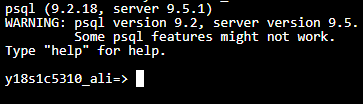

Then on the psql prompt, give the following SQL create table statement:

In [12]:
DROP TABLE IF EXISTS Organisation;
CREATE TABLE IF NOT EXISTS Organisation (
   code VARCHAR(20) PRIMARY KEY,
   organisation    VARCHAR(150)
);

SyntaxError: invalid syntax (<ipython-input-12-30aaa45f4b7f>, line 1)

You can verify whether you created the table correctly with the \d command:

In [ ]:
\d
\d organisation

You should see the following:
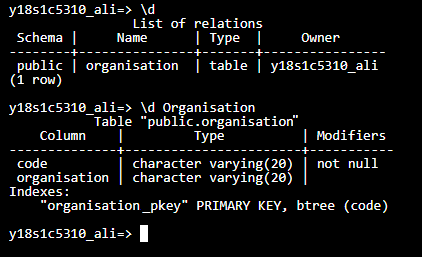


### CSV File Loading, Part 1: Organisations Data 
Next we want to load data from an external CSV file.
We will use psql's **\copy** command for this.

**Prerequisites:** Make sure, that you have uploaded the CSV files and that the filenames are as specified at the top of this notebook. Note: If you store your notebook files in a subdirectory, then you must specify this directory name too when loading the CSV file (or __cd__ into that directory first before starting __psql__).

To load data from a CSV file into a relational database, we have to tell the system
 - into which table to load the data ('Organisations')
 - which attributes to expect; this is optional, but if you are unsure whether the order in the CSV columns matches the order of attributes in a table, it is best to specify it here. Basically in our example, we specify that we will read 'code' and 'organisation' values from the CSV file in this order.
 - from which file to load the data; be sure to use **\copy** rather than just COPY so that you can use a relative filename relative to the current directory
 - which format to expect (CSV) and whether there is a header row that should be ignored (yes, it is - HEADER)

So with all this, the final command to load the Organisation table is as follows.
Please type into the psql prompt at the terminal:

\copy Organisation (code,organisation) FROM 'Organisations.csv' WITH CSV HEADER
   
 select * from organisation;  
    

You should see the following: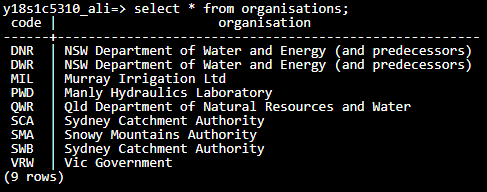

### Database Creation, Part 2: Measurements Table

Psql's <tt>\copy</tt> command is quite useful -- as long as _table and CSV files directly match_, and as long as the CSV file's content is in good shape. Otherwise it soon reaches its limits.

For example lets try using <tt>\copy</tt> for loading the next file with Measurements data.
We first have to create a new table again. Enter the following SQL command at the psql prompt to create a new table:

    DROP TABLE IF EXISTS Measurement;

    CREATE TABLE IF NOT EXISTS Measurement (
              station   VARCHAR(20),
              date DATE,
              level  FLOAT,
              meanDischarge FLOAT,
              discharge  FLOAT,
              temp FLOAT,
              ec  FLOAT
    );
    
Check whether the table has been created correctly:

        \d measurement
        
You should see the following:
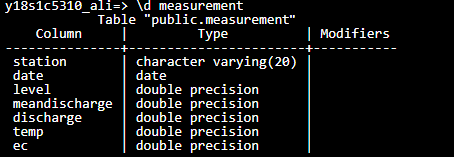

## Your Task: CSV File Loading, Part 2: Measurements Data 

Next try to load the corresponding Measurements.csv CSV data for Measurements data using the psql \COPY command: 

If you have problems loading this data in the first go, have a look at the raw 'Measurements.csv' CSV file and try to identify its cause.

There is an option we have with <tt>\copy</tt> to define that mismatching entries should be replaced with the special NULL value of SQL. You can do so with the **NULL** option. For example:

    \copy <table> FROM <source> WITH CSV HEADER NULL 'x'
    
If you run this command, you tell <tt>\copy</tt> to ignore all 'x' in the CSV file and replace them with a NULL entry instead. You can check you success with the following SQL query after the correct <tt>\copy</tt> command:

    SELECT * FROM <table>;

In [ ]:
# TODO: replace the content of this cell with your psql solution
raise NotImplementedError


This looks already quite promising, but note a few shortcomings of this approach with <tt>\copy</tt>:
- The CSV columns have to match 1:1 the table schema in the database
- We can replace mismatching entries with NULL, but nothing else (eg. no NaN for not-a-number)
- We can only replace one well-defined data mismatch, not multiple
- There is no mechanism to call a user-defined conversion function for such data where we need to convert it first

Basically <tt>\copy</tt> is a very good and fast approach to load well-formed data, such as a previous database export, into a PostgreSQL database. It does not help us if the data is not so well behaved, or if we have to split and load data into separate tables.

## EXERCISE 2: Data Loading and Database Creation with Python

Next we are back to Python. We continue with the same Python environment than last week: the `DictReader` from the `csv` module which support reading and writing of files in comma-separated values (CSV).

Make sure that you have uploaded the 'Organisations.csv' CSV file into Jupyter.
We will first load the content of this file into Python with the same  csv.DictReader()  mechanism than last week:

In [ ]:
import csv
import pprint
data_organisations = list(csv.DictReader(open('Organisations.csv')))
pprint.pprint(data_organisations[0])

For larger data sets, the following would normally be executed as a stand alone Python program on a shell.
First, you need to establish a connection to the postgresql database. 
__Please edit the unikey and SID variables in below's code to match your Jupyter login.__

In [ ]:
import psycopg2

def pgconnect():
    # please replace <your_unikey> and <your_SID> with your own details
    YOUR_UNIKEY = 'ali'#'<your_unikey>'
    YOUR_PW     = 'Char8859'#'<your_SID>'
    try: 
         #conn = psycopg2.connect(host='soit-db-pro-2.ucc.usyd.edu.au',
        #                        database='y18s1d2001_'+YOUR_UNIKEY,
        #                        user='y18s1d2001_'+YOUR_UNIKEY, 
        #                        password=YOUR_PW)
        
        conn = psycopg2.connect(host='localhost', database='waterinfo', user='matloob', password='matloob')
        
        print('connected')
    except Exception as e:
        print("unable to connect to the database")
        print(e)
    return conn

We will need to execute some SQL statements against the database. As we will have to do so multiple times, we write a dedicated function for executing an arbitrary SQL statement, where we do not expect any result. This handles then also all failures and using psycopg2's 'with' statements also the transaction processing of the database. Below's code will for example automatically commit our SQL statements, as well as rollback if there was any error.

In [ ]:
def pgexec( conn, sqlcmd, args, msg, silent=False ):
   """ utility function to execute some SQL statement
       can take optional arguments to fill in (dictionary)
       error and transaction handling built-in """
   retval = False
   with conn:
      with conn.cursor() as cur:
         try:
            if args is None:
               cur.execute(sqlcmd)
            else:
               cur.execute(sqlcmd, args)
            if silent == False: 
                print("success: " + msg)
            retval = True
         except Exception as e:
            if silent == False: 
                print("db error: ")
                print(e)
   return retval

Now let's load our previous data.
Important: whenever you use this approach, make sure that the header line of your CSV file has no spaces in its column titles and also no quotes. Otherwise, the csv.DictReader might be fine to read it, but not the psycopg2's cursor.execute() function. We are using named placeholders in out INSERT statement below (eg. '%(SiteName)s' ) which expects to put a string (%s) into that place of the INSERT statement as been found in the given dictionary for the execute() call with the key 'SiteName'.

In [ ]:
# 1st: login to database
conn = pgconnect()

# if you want to reset the table
pgexec (conn, "DROP TABLE IF EXISTS Organisation", None, "Reset Table Organisation")

# 2nd: ensure that the schema is in place

organisation_schema = """CREATE TABLE IF NOT EXISTS Organisation (
                         code VARCHAR(20) PRIMARY KEY,
                         orgName VARCHAR(150)
                   )"""
pgexec (conn, organisation_schema, None, "Create Table Organisation")

# 3nd: load data
# IMPORTANT: make sure the header line of CSV is without spaces!
insert_stmt = """INSERT INTO Organisation(code,orgName) VALUES (%(Code)s, %(Organisation)s)"""
for row in data_organisations:
    pgexec (conn, insert_stmt, row, "row inserted")



Next let's check whether this has all worked fine by querying our PostgreSQL database again.
You of course can go back to the Terminal page and in pgsql simply type   SELECT * FROM Organisation

Or we do it here in Python again. To do so, we introduce first another utility function which again encapsulates all error and transaction handling. Then we query the new Organisation table and simply print out all tuples found.

In [ ]:
def pgquery( conn, sqlcmd, args, silent=False ):
   """ utility function to execute some SQL query statement
       can take optional arguments to fill in (dictionary)
       will print out on screen the result set of the query
       error and transaction handling built-in """
   retval = False
   with conn:
      with conn.cursor() as cur:
         try:
            if args is None:
                cur.execute(sqlcmd)
            else:
                cur.execute(sqlcmd, args)
            if silent == False:
                for record in cur:
                    print(record)
            retval = True
         except Exception as e:
            if silent == False:
                print("db read error: ")
                print(e)
   return retval

In [ ]:

# check content of Organisation table
query_stmt = "SELECT * FROM Organisation"
print(query_stmt)
pgquery (conn, query_stmt, None)

# cleanup...   Needed already?  Better not now... 
# But keep in mind to close connection eventually!
# conn.close()

## Your Task: Data Loading

Try to create and load the Measurement table.

    1.read the Measurements csv file
    2. Create a matching 'Measurement' table to hold the CSV data
    3. Load the content of the csv file into a local 'data_measurements' dictionary in Python
    4. Load the data from the 'data_measurements' dictionary into your PostgreSQL table
    5. Query and print its content

In [ ]:
# TODO: replace the content of this cell with your Python + psycopg2 solution
raise NotImplementedError



## EXERCISE 3: Data Cleaning

### Data Cleaning
We re-use the clean() function from last week.

In [ ]:
import numpy as np
DEFAULT_VALUE = np.nan

def clean(data, column_key, convert_function, default_value):
    special_values= {} # no special values yet
    for row in data:
        old_value = row[column_key]
        new_value = default_value
        try:
            if old_value in special_values.keys():
                new_value = special_values[old_value]
            else:
                new_value = convert_function(old_value)
        except (ValueError, TypeError):
            print('Replacing {} with {} in column {}'.format(row[column_key], new_value, column_key))
        row[column_key] = new_value
             

In [ ]:
# this conversion strips any leading or trailing spaces from the 'Station' values
clean(data_measurements, 'Station', str.strip, DEFAULT_VALUE)

# the following converts the two measurment  columns to float  values - or NaN
clean(data_measurements, 'Discharge', float, DEFAULT_VALUE)
clean(data_measurements, 'MeanDischarge', float, DEFAULT_VALUE)
clean(data_measurements, 'Level', float, DEFAULT_VALUE)
clean(data_measurements, 'Temp', float, DEFAULT_VALUE)
clean(data_measurements, 'EC', float, DEFAULT_VALUE)

##now we insert the  data_measurements into the 'Measurement' table 
# 1st: login to database
if(conn):
    conn.close();
conn = pgconnect()

# 2nd: ensure that the schema is in place
pgexec (conn, "DROP TABLE IF EXISTS Measurement", None, "Reset Table Measurement")
measurement_schema = """CREATE TABLE IF NOT EXISTS Measurement (
                         station   VARCHAR(20),
                         date DATE,
                         level  FLOAT,
                         meanDischarge FLOAT,
                         discharge  FLOAT,
                         temp FLOAT,
                         ec  FLOAT
                      )"""
pgexec (conn, measurement_schema, None, "Create Table Measurement")

# 3nd: load data
# IMPORTANT: make sure the header line of CSV is without spaces!
insert_stmt = """INSERT INTO Measurement(station,date,level,meandischarge,discharge,temp,ec)
                      VALUES (%(Station)s, %(Date)s, %(Level)s,%(MeanDischarge)s,%(Discharge)s,%(Temp)s,%(EC)s)"""
for row in data_measurements:
    pgexec (conn, insert_stmt, row, "row inserted")
    
query_stmt = "SELECT COUNT(*) FROM Measurement"
print(query_stmt)
pgquery (conn, query_stmt, None)

## Your Task: Data Cleaning

Use above's  clean()  function to clean the other give data set too.
 1. read the Stations csv file into data_stations
 2. Clean the  'data_stations'  data set
 3. Reload the 'data_stations'  dictionary into your database
 4. Query the 'Stations' table - which difference do you see?
 
 5. If you have time: Do all of the above (reading - cleaning - loading) also for the 'Sensors.csv' data set

Note: You might encounter a few warning and error messages.
   - If a connection is closed, you have to open the databse connection again first
   - If the clean() function returns a warning that some string was replaced with NaN, as long as this is indeed a number attribute, you are Ok to ignore this message. It just tells you that it is doing what it is supposed to do.
   - If you try to insert data into an already existing table with data inside, you might get 'duplicate primary key' error messages. Again, you can ignore those for the moment.
   - If you want to see who much data is already in your table, use the following SQL query:
     -  SELECT COUNT(*) FROM Stations;

In [ ]:
# TODO: replace the content of this cell with your Python solution
raise NotImplementedError


   
  


## Demo: Data Modelling & DB Creation
Next, we will look in the lecture at modelling the data correctly for a normalised relational star schema. We will discuss an example solution for the given water data model in the class.

## Your Homework Task: Data Modelling
Have a look at the Excel workbook and check how we have modeled its content into a normalised relational data model as shown in our proposed relational schema further down in this notebook.

## EXERCISE 4: Database Creation
After we discussed the model, we will give you an example solution (see below).
The next step is to create the corresponding SQL schema in your PostgreSQL database.

### Your Task: DB Creation in PostgreSQL
Create the corresponding tables in PostgreSQL which follow from the data model.

<pre>
DROP TABLE IF EXISTS Organisation CASCADE;
CREATE TABLE IF NOT EXISTS Organisation (
   code VARCHAR(20) PRIMARY KEY,
   organisation    VARCHAR(150)
);

DROP TABLE IF EXISTS Station CASCADE;
CREATE TABLE IF NOT EXISTS Station (
     station   VARCHAR(50) PRIMARY KEY,
     siteName  VARCHAR(50),
     commence Date,
     orgCode  VARCHAR(50),
     CONSTRAINT orgCodeFK FOREIGN KEY (orgCode)   REFERENCES Organisation (code)
 );

DROP TABLE IF EXISTS Sensor CASCADE;
CREATE TABLE IF NOT EXISTS Sensor (
     sensor   VARCHAR(20) PRIMARY KEY,
     description  VARCHAR(150) ,       
     metric VARCHAR(20)                 
  );

DROP TABLE IF EXISTS Measurement CASCADE;
CREATE TABLE IF NOT EXISTS Measurement (
     station   VARCHAR(20),
     sensor   VARCHAR(20),
     date DATE,
     value  FLOAT,
     CONSTRAINT stationFK FOREIGN KEY (station)   REFERENCES Station (Station),
     CONSTRAINT sensorFK FOREIGN KEY (sensor)   REFERENCES sensor (sensor)
  );
                      
</pre>

In [ ]:
# TODO: replace the content of this cell with your Python + SQL solution
raise NotImplementedError
# make sure we are still connected to database 


## EXERCISE 5: Data Loading and Storage

Up-to this point, we have
 - analysed and modelled the given data set
 - created a corresponding relational star schema
 - read the individual CSV files into Python dictionary data structures
 - cleaned the raw data with regard to missing or inconsistent entries and data types
 
The final step is to load this cleaned data into the corresponding tables of the star schema which we defined so far.

For this to work, you probably will need to write some logic to load different parts of different data dictionaries (holding the content of CSV files) into different tables.


In [ ]:
import numpy as np
import csv
import pprint
# Organisation table
data_organisations = list(csv.DictReader(open('water_data/Organisations.csv')))

# make sure we are still connected to database 
if conn is None or conn.closed:
    conn = pgconnect()

# check for any existing content of the Organisations table
query_stmt = "SELECT COUNT(*) FROM Organisation"
print(query_stmt)
pgquery (conn, query_stmt, None)

# Try to load data - 9 tupels should be created
insert_stmt = """INSERT INTO Organisation(code,organisation) VALUES (%(Code)s, %(Organisation)s)"""
for row in data_organisations:
    pgexec (conn, insert_stmt, row, "row inserted")
    
#####################
# Station table    
data_stations = list(csv.DictReader(open('water_data/Stations.csv')))

# IMPORTANT: make sure the header line of CSV is without spaces!
insert_stmt = """INSERT INTO Station(station,siteName,commence,orgCode)
                      VALUES (%(station)s, %(siteName)s, %(commence)s,%(orgCode)s)"""
stationData = dict()
for row in data_stations:
    stationData['station'] = row['BasinNo']+row['Site']
    stationData['siteName']  = row['SiteName']
    stationData['commence'] = row['Commence']
    stationData['orgCode'] = row['OrgCode']
    pgexec (conn, insert_stmt, stationData, "station inserted")

# check content of Station table
query_stmt = "SELECT * FROM Station"
print(query_stmt)
pgquery (conn, query_stmt, None)



#####################
# Sensor table    
data_sensors = list(csv.DictReader(open('water_data/Sensors.csv')))

# IMPORTANT: make sure the header line of CSV is without spaces!
insert_stmt = """INSERT INTO Sensor(sensor,description,metric)
                      VALUES (%(sensor)s, %(description)s, %(metric)s)"""

for row in data_sensors:
    pgexec (conn, insert_stmt, row, "sensor inserted")

# check content of Station table
query_stmt = "SELECT * FROM Sensor"
print(query_stmt)
pgquery (conn, query_stmt, None)


#####################
# Measurement table    
data_measurements = list(csv.DictReader(open('water_data/Measurements.csv')))

# the following converts the two measurment  columns to float  values - or NaN
clean(data_measurements, 'Discharge', float, DEFAULT_VALUE)
clean(data_measurements, 'MeanDischarge', float, DEFAULT_VALUE)
clean(data_measurements, 'Level', float, DEFAULT_VALUE)
clean(data_measurements, 'Temp', float, DEFAULT_VALUE)
clean(data_measurements, 'EC', float, DEFAULT_VALUE)

# IMPORTANT: make sure the header line of CSV is without spaces!
insert_stmt = """INSERT INTO Measurement(station,date,sensor,value)
                      VALUES (%(station)s, %(date)s, %(sensor)s, %(value)s)"""

measurementData = dict()
sensorCodes = ['levl', 'disvol','disc','temp', 'ec']
sensor_columns = ['Level', 'MeanDischarge', 'Discharge','Temp', 'EC']
for row in data_measurements:
    measurementData['station'] = row['Station']
    measurementData['date'] = row['Date']
    for i in range(len(sensorCodes)):
        if(np.isnan(row[sensor_columns[i]])):
            continue;
        measurementData['sensor'] = sensorCodes[i]
        measurementData['value']  = row[sensor_columns[i]]
        pgexec (conn, insert_stmt, measurementData, "measurement inserted")
    

# check content of Measurement table
query_stmt = "SELECT * FROM Measurement"
print(query_stmt)
pgquery (conn, query_stmt, None)

query_stmt = "SELECT count(*) FROM Measurement"
print(query_stmt)
pgquery (conn, query_stmt, None)
conn.close();

## Your Task: Data Storage in PostgreSQL
Following the above pattern, make sure all the   tables of our water schema ar loaded with the data from the different CSV files.

In [ ]:
# TODO: replace the content of this cell with your Python + SQL solution
raise NotImplementedError

# End of Tutorial. Many Thanks.